## 基于多树GP的特征工程（Feature Construction）
在机器学习中，特征工程是非常重要的一环。特征工程的目的是从原始数据中提取出更有用的特征，以提高机器学习算法的性能。  
特征工程的方法有很多，比如特征降维（PCA、ICA、LDA）、特征选择、特征构造等。其中，特征构造是指从原始数据中构造出新的特征，以提高机器学习算法的性能。  
特征构造的方法有很多，比如多项式特征构造、基于树的特征构造、基于聚类的特征构造、基于神经网络的特征构造等。  
本文将介绍如何使用遗传编程（GP）来进行特征构造。遗传编程是一种进化算法，基于树结构演化，它很适合用于构造机器学习算法所需的特征。  

### 评估函数
特征工程是指遗传编程（GP）用于构造机器学习算法所需的特征，而后续的预测操作由机器学习算法来执行。因此，评估函数内部需要内置机器学习算法或特征质量评估函数。
值得一提的是，如果使用机器学习算法进行评估，为了避免过拟合，最好使用交叉验证误差来评估特征工程的效果。

In [47]:
from sklearn.datasets import load_iris

# 假设我们有一个分类问题，输入为X，输出为y
X, y = load_iris(return_X_y=True)


# 求解问题的目标是最大化分类精度
def evalFeatureEngineering(individuals):
    # 创建新特征
    new_features = []
    for ind_num, ind in enumerate(individuals):
        func = gp.compile(expr=ind, pset=pset)
        new_features.append([func(*record) for record in X])

    # 转置新特征数组
    new_features = np.transpose(np.array(new_features))

    # 使用决策树分类器
    clf = DecisionTreeClassifier()
    clf.fit(new_features, y)

    # 使用交叉验证计算误差
    scores = cross_val_score(clf, new_features, y, cv=5)

    # 返回平均分类精度
    return scores.mean(),

### 多树GP 个体表示
实现多树GP的方法有很多，最简单的方式是使用列表结构来表示一个个体，列表中的每个元素都是一棵树。
当然，为了后续的可扩展性，更建议创建一个类来表示个体，类中包含一个列表，列表中的每个元素都是一棵树。不过，这里为了简单起见，我们直接使用列表结构。

In [48]:
import operator
import random
import numpy as np
from deap import base, creator, tools, gp, algorithms
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# 创建GP框架的基本组件
pset = gp.PrimitiveSet("MAIN", X.shape[1])
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
pset.addEphemeralConstant("rand101", lambda: random.random() * 2 - 1)

# 创建一个适应度类和个体类，个体由多棵树组成
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

C:\Users\zhenl\anaconda3\Lib\site-packages\deap\gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "
C:\Users\zhenl\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\zhenl\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


### 交叉/变异算子
对于多树GP，很明显我们还需要自己定义交叉和变异算子。这里我们对DEAP中的交叉和变异算子进行简单包装，将其改造成能够处理多棵树的列表结构的算子。

In [49]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=6)


# 初始化每个个体为一个包含多棵树的列表
def initIndividual(container, func, size):
    return container(gp.PrimitiveTree(func()) for _ in range(size))


# 交叉和变异算子需要能够处理个体的列表结构
def cxOnePointListOfTrees(ind1, ind2):
    for idx, (tree1, tree2) in enumerate(zip(ind1, ind2)):
        HEIGHT_LIMIT = 5
        dec = gp.staticLimit(key=operator.attrgetter("height"), max_value=HEIGHT_LIMIT)
        tree1, tree2 = dec(gp.cxOnePoint)(tree1, tree2)
        ind1[idx], ind2[idx] = tree1, tree2
    return ind1, ind2


def mutUniformListOfTrees(individual, expr, pset):
    for idx, tree in enumerate(individual):
        HEIGHT_LIMIT = 5
        dec = gp.staticLimit(key=operator.attrgetter("height"), max_value=HEIGHT_LIMIT)
        tree, = dec(gp.mutUniform)(tree, expr=expr, pset=pset)
        individual[idx] = tree
    return (individual,)


toolbox.register("individual", initIndividual, creator.Individual, toolbox.expr, size=3)  # 假设我们创建3个特征
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evalFeatureEngineering)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", cxOnePointListOfTrees)
toolbox.register("mutate", mutUniformListOfTrees, expr=toolbox.expr, pset=pset)
toolbox.register("compile", gp.compile, pset=pset)

最后，演化流程与传统的GP算法没有区别。直接运行即可。

In [50]:
# 运行遗传编程算法
population = toolbox.population(n=50)
hof = tools.HallOfFame(1)

# 统计和日志
stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values)
stats_size = tools.Statistics(key=lambda ind: max([tree.height for tree in ind]))
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(population, toolbox, 0.9, 0.1, 10, stats=mstats, halloffame=hof, verbose=True)

# 查看最佳个体
best_ind = hof[0]
print('Best individual is:', [str(tree) for tree in best_ind])
print('With fitness:', best_ind.fitness.values)

   	      	                             fitness                             	                      size                     
   	      	-----------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max 	min     	nevals	std      	avg 	gen	max	min	nevals	std    
0  	50    	0.897733	0  	0.96	0.606667	50    	0.0803615	4.44	0  	6  	1  	50    	1.31393
1  	49    	0.922667	1  	0.98	0.506667	49    	0.0709679	4.26	1  	6  	1  	49    	1.21342
2  	49    	0.934267	2  	0.966667	0.693333	49    	0.0399335	4.34	2  	5  	2  	49    	0.907965
3  	46    	0.9368  	3  	0.98    	0.846667	46    	0.0317837	4.4 	3  	5  	2  	46    	0.824621
4  	44    	0.939733	4  	0.98    	0.766667	44    	0.0317479	4.14	4  	5  	2  	44    	1.0002  
5  	46    	0.941067	5  	0.986667	0.813333	46    	0.0279479	4.02	5  	5  	1  	46    	1.22458 
6  	50    	0.932667	6  	0.973333	0.693333	50    	0.0466714	3.56	6  	5  	1  	50    	1.23548 
7  	46    	0.949867	7  	0.973

当然，最后也可以利用NetworkX库来对所有GP树进行可视化。

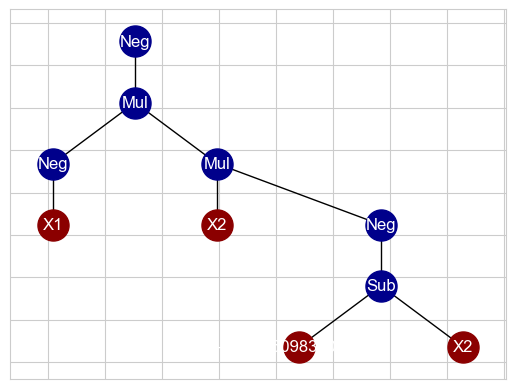

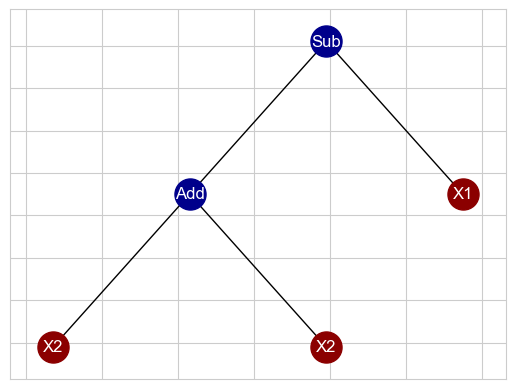

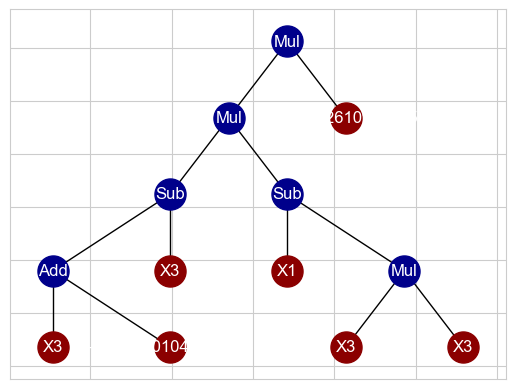

In [51]:
from matplotlib import pyplot as plt
import networkx as nx
from deap.gp import graph
from networkx.drawing.nx_agraph import graphviz_layout

function_name = {
    'add': 'Add',
    'sub': 'Sub',
    'mul': 'Mul',
    'neg': 'Neg'
}


def is_number(string):
    try:
        float(string)
        return True
    except ValueError:
        return False


def plot_a_tree(tree=hof[0]):
    red_nodes = []
    purple_nodes = []
    blue_nodes = []
    for gid, g in enumerate(tree):
        if (
                hasattr(g, "value")
                and isinstance(g.value, str)
                and g.value.startswith("ARG")
        ):
            g.value = g.value.replace("ARG", "X")

        if g.name in function_name:
            g.name = function_name[g.name]

        if hasattr(g, "value") and (
                is_number(g.value)
                or (g.value.startswith("X") and int(g.value[1:]) < X.shape[1])
        ):
            # 基础节点
            red_nodes.append(gid)
        elif hasattr(g, "value") and g.value.startswith("X"):
            g.value = "$\phi$" + str(int(g.value.replace("X", "")) - X.shape[1] + 1)
            purple_nodes.append(gid)
        elif hasattr(g, "value") and g.value.startswith("$\phi$"):
            purple_nodes.append(gid)
        else:
            # 深蓝色节点
            blue_nodes.append(gid)
    nodes, edges, labels = graph(tree)
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = graphviz_layout(g, prog="dot")
    red_nodes_idx = [nodes.index(n) for n in nodes if n in red_nodes]
    purple_nodes_idx = [nodes.index(n) for n in nodes if n in purple_nodes]
    blue_nodes_idx = [nodes.index(n) for n in nodes if n in blue_nodes]
    nx.draw_networkx_nodes(
        g, pos, nodelist=red_nodes_idx, node_color="darkred", node_size=500
    )
    nx.draw_networkx_nodes(
        g, pos, nodelist=purple_nodes_idx, node_color="indigo", node_size=500
    )
    nx.draw_networkx_nodes(
        g, pos, nodelist=blue_nodes_idx, node_color="darkblue", node_size=500
    )
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels, font_color="white")


for tree in hof[0]:
    plot_a_tree(tree)
    plt.show()